In [4]:
import matplotlib.pyplot as plt
import numpy as np

In [5]:
symbols = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'

img_width = 140
img_height = 80
n_class = len(symbols) # len(symbols) == 36
num_char = 4

# Data generator

In [98]:
from captcha.image import ImageCaptcha
import random

def gen(batch_size=64, save_img = False, save_dir = ''):
    X = np.empty((batch_size, img_height, img_width, 3), dtype=np.uint8)
    Y = [np.empty((batch_size, n_class), dtype=np.uint8) for i in range(num_char)]
    generator = ImageCaptcha(width=img_width, height=img_height)
    while True:
        for i in range(batch_size):
            random_str = ''.join(random.sample(symbols, num_char))
            img = generator.generate_image(random_str)
            if save_img == True:
                plt.imsave(save_dir+random_str+".jpg",np.array(img))
            X[i] = img
            for digit, ch in enumerate(random_str):
                Y[digit][i, :] = 0
                Y[digit][i, symbols.find(ch)] = 1
        yield X, Y
        
# Decoder
def decode(y):
    y = np.argmax(np.array(y), axis=2)[:,0]
    return ''.join([symbols[c] for c in y])

# Test

(-0.5, 139.5, 79.5, -0.5)

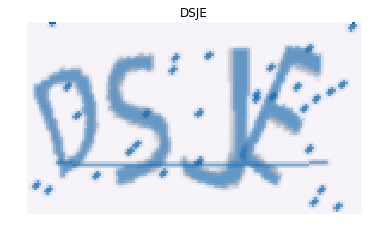

In [78]:
(X, y) = next(gen(1))
plt.imshow(X[0])
plt.title(decode(y))
plt.axis('off')

# CNN

In [5]:
from keras.models import *
from keras.layers import *

input_layer = Input(shape = (img_height, img_width, 3))
layers = Conv2D(32, (3, 3), activation='relu')(input_layer)
layers = Conv2D(32, (3, 3), activation='relu')(layers)
layers = MaxPooling2D((2, 2))(layers)

layers = Conv2D(64, (3, 3), activation='relu')(layers)
layers = Conv2D(64, (3, 3), activation='relu')(layers)
layers = MaxPooling2D((2, 2))(layers)

layers = Conv2D(128, (3, 3), activation='relu')(layers)
layers = Conv2D(128, (3, 3), activation='relu')(layers)
layers = MaxPooling2D((2, 2))(layers)

layers = Conv2D(256, (3, 3), activation='relu')(layers)
layers = Conv2D(256, (3, 3), activation='relu')(layers)
layers = MaxPooling2D((2, 2))(layers)

layers = Flatten()(layers)
layers = Dropout(0.2)(layers)
layers = [Dense(n_class, activation='softmax',  name='digit_%d'%i)(layers) for i in range(4)]

model = Model(inputs = input_layer, outputs = layers)

model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

# Training

In [6]:
batch_size = 256
samples =64000
val_samples = 1024
h = model.fit_generator(gen(batch_size = batch_size), steps_per_epoch = samples/batch_size, epochs=5,
                        validation_data=gen(batch_size = batch_size), validation_steps = val_samples/batch_size, 
                        verbose = 1)

Epoch 1/5
 - 1604s - loss: 1.9347 - digit_0_loss: 0.5262 - digit_1_loss: 0.4415 - digit_2_loss: 0.4864 - digit_3_loss: 0.4806 - digit_0_acc: 0.8651 - digit_1_acc: 0.8892 - digit_2_acc: 0.8775 - digit_3_acc: 0.8786 - val_loss: 1.4221 - val_digit_0_loss: 0.3418 - val_digit_1_loss: 0.3615 - val_digit_2_loss: 0.3646 - val_digit_3_loss: 0.3542 - val_digit_0_acc: 0.9712 - val_digit_1_acc: 0.9683 - val_digit_2_acc: 0.9651 - val_digit_3_acc: 0.9650
Epoch 2/5
 - 1611s - loss: 0.4750 - digit_0_loss: 0.1143 - digit_1_loss: 0.1147 - digit_2_loss: 0.1241 - digit_3_loss: 0.1219 - digit_0_acc: 0.9858 - digit_1_acc: 0.9848 - digit_2_acc: 0.9829 - digit_3_acc: 0.9838 - val_loss: 1.0797 - val_digit_0_loss: 0.2613 - val_digit_1_loss: 0.2715 - val_digit_2_loss: 0.2761 - val_digit_3_loss: 0.2709 - val_digit_0_acc: 0.9729 - val_digit_1_acc: 0.9696 - val_digit_2_acc: 0.9699 - val_digit_3_acc: 0.9700
Epoch 3/5
 - 1619s - loss: 0.6004 - digit_0_loss: 0.1453 - digit_1_loss: 0.1453 - digit_2_loss: 0.1556 - digit

# Testing accuracy of trained model

In [77]:
def evaluate(model, test_num=1000):
    correct = 0
    generator = gen(1,save_img = False, save_dir = 'test_img/')
    for i in range(test_num):
        X, y = next(generator)
        y_pred = model.predict(X)
        y = decode(y)
        y_pred = decode(y_pred)
        #print(y, y_pred)
        if y == y_pred:
            correct += 1
        else:
            print(y, y_pred) #print wrong prediction
    return correct / test_num

evaluate(model)

OH9W 0H9W
GDIO GDI0
J05V JO5V
0B3Y OB3Y
9DQ7 9DQZ
Z3RP Z3RR
E09D EO9D
C0I9 COI9
5ETD 5E7D
QLY9 QLJ9
GEN0 GENO
QN6O QN60
N067 NO67
WX04 WXO4
4Z02 4ZO2
SM0G SMOG
B6WO B6W0
0TN4 OTN4


0.982

# Test Sample

(-0.5, 139.5, 79.5, -0.5)

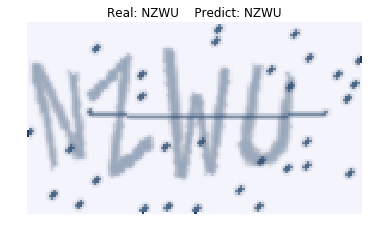

In [99]:
X, y = next(gen(1))
y_pred = model.predict(X)
plt.title('Real: %s    Predict: %s'%(decode(y), decode(y_pred)))
plt.imshow(X[0], cmap='gray')
plt.axis('off')

# Save/Load model

In [9]:
model.save('CAPTCHA_Cracker.h5')

In [2]:
from keras.models import load_model
model = load_model('Captcha_Cracker.h5')

c:\users\zhongzhu\anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
